# Variable free stream
In this notebook we will simulate the flow with a time-varying free stream past a
stationary body. To demonstrate this, we will solve for oscillatory flow past a
rectangular object, in which the $x$ component of the free stream is

$$U_\infty(t) = A \sin(\Omega t)$$

In [1]:
using ViscousFlow

In [2]:
using Plots
using Statistics

### Problem specification
We will set the Reynolds number to 200

In [3]:
my_params = Dict()
my_params["Re"] = 200

200

In order to set a time-varying free stream, we have to define a function
that provides the instantaneous free stream components and pass that
function into the system definition. In this function, we will
use the `OscillatoryDOF` function (available via the [RigidBodyTools.jl](https://github.com/JuliaIBPM/RigidBodyTools.jl) package)
to create the modulated free stream. To demonstrate its possibilities,
we will pass in the parameters for the sinusoid via the `my_params` dictionary.
The "freestream average" specifies a mean free stream, if desired.

In [4]:
my_params["freestream average"] = 0.0
my_params["freestream frequency"]  = 2.0
my_params["freestream amplitude"] = 0.5
my_params["freestream phase"] = 0.0

0.0

Now we define the function. We can call it anything we want,
but it has to have the argument signature as shown. The
`Sinusoid` function is used, with the shift operator `>>`
to apply any phase lag.

In [5]:
function my_freestream(t,phys_params)
    U = phys_params["freestream average"]
    Ω = phys_params["freestream frequency"]
    Ax = phys_params["freestream amplitude"]
    ϕx = phys_params["freestream phase"]
    kin = OscillatoryDOF(Ax,Ω,ϕx,U)

    Vinf_angle = get(phys_params,"freestream angle",0.0)
    Vinf_amp = dof_velocity(kin(t))

    Uinf = Vinf_amp*cos(Vinf_angle)
    Vinf = Vinf_amp*sin(Vinf_angle)
    return Uinf, Vinf
end

my_freestream (generic function with 1 method)

The freestream function is passed in via the "freestream" key in the
parameters Dict.

In [6]:
my_params["freestream"] = my_freestream

my_freestream (generic function with 1 method)

Now let us carry on with the other usual steps:

### Discretize

In [7]:
xlim = (-2.0,2.0)
ylim = (-1.5,1.5)
my_params["grid Re"] = 4.0
g = setup_grid(xlim,ylim,my_params)

PhysicalGrid{2}((208, 160), (104, 80), 0.02, ((-2.06, 2.06), (-1.58, 1.58)), 10)

### Set up bodies
Here, we will set up an ellipse in the center of the domain

In [8]:
Δs = surface_point_spacing(g,my_params)
body = Ellipse(0.25,0.5,Δs)

joint = Joint(RigidTransform([0.0,0.0],0.0))
m = RigidBodyMotion(joint,body)
x = init_motion_state(body,m)
update_body!(body,x,m)

Elliptical body with 84 points and semi-axes (0.25,0.5)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


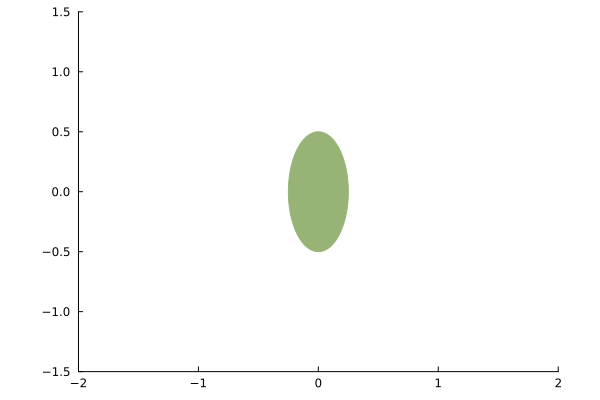

In [9]:
plot(body,xlim=xlim,ylim=ylim)

### Construct the system structure
This step is like the previous notebooks:

In [10]:
sys = viscousflow_system(g,body,phys_params=my_params,motions=m);

### Initialize
Now, we initialize with zero vorticity

In [11]:
u0 = init_sol(sys)

(Dual nodes in a (nx = 208, ny = 160) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 160), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

and create the integrator

In [12]:
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 208, ny = 160) cell grid of type Float64 data
  Number of Dual nodes: (nx = 208, ny = 160), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 2.5$.

In [13]:
@time step!(integrator,2.5)

 15.020935 seconds (10.94 M allocations: 1.978 GiB, 0.97% gc time, 21.93% compilation time)


### Examine
Let's look at the flow field at the end of this interval

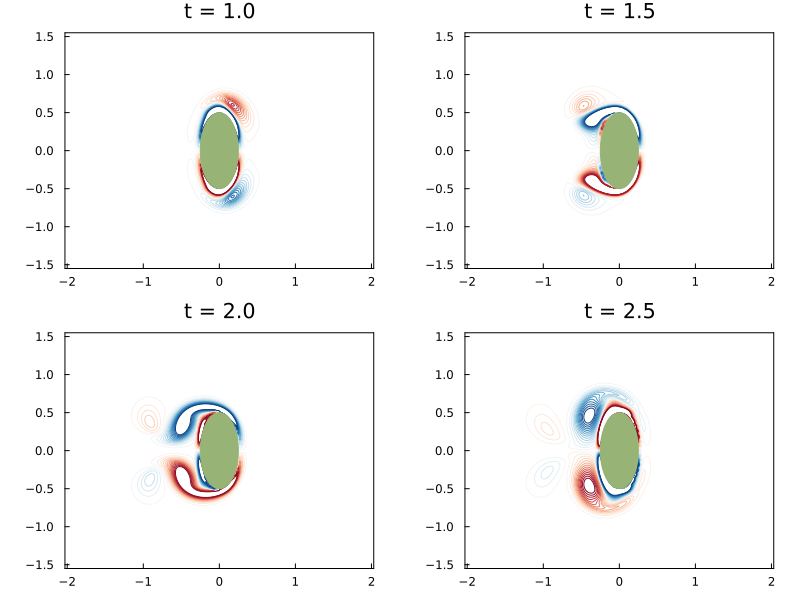

In [14]:
sol = integrator.sol
plt = plot(layout = (2,2), size = (800, 600), legend=:false)
tsnap = 1.0:0.5:2.5
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,layers=false,title="t = $(round(t,digits=2))",clim=(-10,10),levels=range(-10,10,length=30),color = :RdBu)
    plot!(plt[i],surfaces(sol,sys,t))
end
plt

#### Compute the force history
Just as we did for the stationary body in a constant free stream

In [15]:
fx, fy = force(sol,sys,1);

Plot them

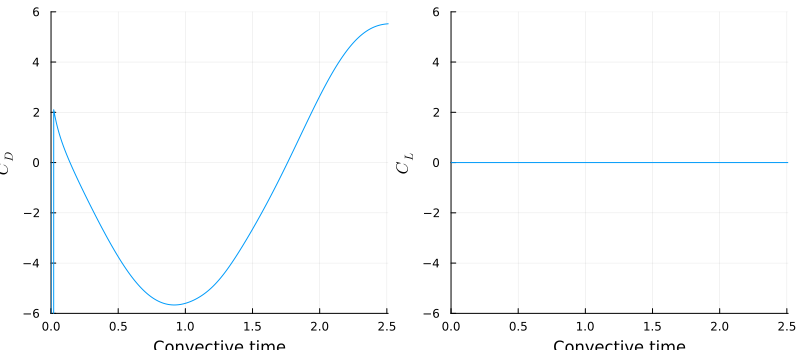

In [16]:
plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(-6,6),xlabel="Convective time",ylabel="\$C_D\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=:false),
    size=(800,350)
)

The mean drag and lift coefficients are

In [17]:
meanCD = mean(2*fx[3:end])

-1.23075742644489

In [18]:
meanCL = mean(2*fy[3:end])

2.9000221845588666e-11

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*